# Bandwidth analysis

In this Notebook the effect of changing the reciever bandwidth will be investigated. This parameter determines the number of frequencies in each pixel, Hz/pixel, for the resulting image. When it comes to geometric distortions in line-by-line acquisition, these frequency shifts firectly encodes for the localization of the signal along FE direction, and we will therefore get a signal shift in a direction dependent on the RO direction of k-space for that line. For example, reading of k-space from left to right will shift a boundary towards the right. The severity of the shift depends on the reciever bandwidth, which we here will look more into.

In [115]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import sobel
from skimage.measure import find_contours
import matplotlib.gridspec as gridspec

# Set LaTeX to render with Computer Modern font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering

In [116]:
folder_data = '/Users/hannerokstad/Desktop/Project_NTNU/Data/BILLY_PHANTOM_24_10_10-11_10_40-DST-1_3_12_2_1107_5_2_0_79123/JOHANNA_LAURAPHD_20241010_111131_730000/'

# Folder for all different images
folder_TE = 'BW/'

In [117]:
# Function for cropping image
def crop_image(image, x1, x2, y1, y2):
    '''
    Function for cropping an image.
    
    Input:
    image: 2D numpy array
    x1, x2, y1, y2 (int): Coordinates for cropping
    
    Output:
    Cropped image
    '''
    return image[x1:x2, y1:y2]

In [118]:
def load_images(bw, num, echo):
    '''
    Function for loading images from different BW and echo times
    
    Input:
    bw: List of bandwidths
    num: List of filenumbers
    echo: Echo time wanted to extract. (1 (first) or 2 (second))
    
    Output:
    images: List of all images
    images_cropped: List of cropped images
    img_cropped_boundary: List of even finer cropped images
    '''
    # make list for storing all images
    images = []
    images_cropped = []
    img_cropped_boundary = []

    # Directory to each BW
    for i in range(len(bw)):
        dir_bw = 'MGE_2TE_1P5MM_' + str(bw[i]) + 'HZ_00' + str(num[i]) + '/2TE_1P5MM_' + str(bw[i]) + 'HZ_00' + str(num[i]) + '_e' + str(echo) + '.nii.gz'
        data = nib.load(folder_data + folder_TE + dir_bw)
        img = np.rot90(data.get_fdata(), 1) # Image stack is rotated when given
        images.append(img)

        # Also save a cropped version
        img_cropped = crop_image(img, 150, 340, 125, 375)
        images_cropped.append(img_cropped)

        # Add an even finer cropped image of roi
        img_roi = crop_image(img_cropped, 70, 150, 45, 175)
        img_cropped_boundary.append(img_roi)

    return images, images_cropped, img_cropped_boundary

In [119]:
bw = [500, 250, 120, 60] # 500Hz too low SNR to give reasonable roi mean and median. 250Hz as reference instead

# Corresponding filenumbering
num = [32, 30, 34, 36]

images, images_cropped, img_cropped_boundary = load_images(bw, num, 1)
images_e2, images_cropped_e2, img_cropped_boundary_e2 = load_images(bw, num, 2)

In [120]:
# Get the reference images of 250Hz
ref_img = images[1]
ref_img_cropped = images_cropped[1]
ref_img_boundary = img_cropped_boundary[1]

## Difference map

In [121]:
def plot_difference_map(img_idx):
    '''
    Function for plotting the difference map between the reference image and the other images.
    
    Input:
    img_idx (int): Index of the image to plot the difference map for
    '''
    # Calculate the global min and max values across all difference images for same colorbar
    min_val = np.min([np.min(img_cropped_boundary[i][:, :, img_idx] - ref_img_boundary[:, :, img_idx]) for i in range(4)])
    max_val = np.max([np.max(img_cropped_boundary[i][:, :, img_idx] - ref_img_boundary[:, :, img_idx]) for i in range(4)])

    # Set up a figure with GridSpec for more control over layout
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.01, hspace=0.001)  # Minimal spacing

    axs = []
    for i in range(4):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        axs.append(ax)
        
        if i == 1:
            img = ax.imshow(ref_img_boundary[:, :, img_idx], cmap='gray')
        else:
            img_diff = img_cropped_boundary[i][:, :, img_idx] - ref_img_boundary[:, :, img_idx]
            img = ax.imshow(img_diff, cmap='bwr', vmin=min_val, vmax=max_val)

        ax.axis('off')  # Turn off axes for all subplots
        axs[i].text(0.5, -0.1, f'{bw[i]}Hz', ha='center', va='center', transform=axs[i].transAxes, fontsize=16)


    # Add a single colorbar to the right of all subplots
    cbar = fig.colorbar(img, ax=axs, orientation='vertical', shrink = 0.75, pad=0.04)
    cbar.set_label('A.U.', rotation=0, labelpad = 15)
    plt.show()


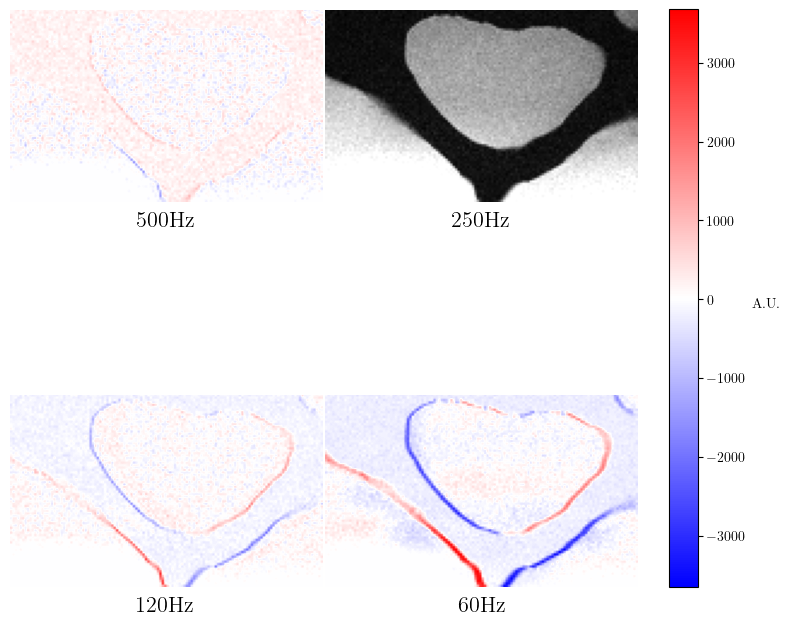

In [122]:
img_idx = 13
plot_difference_map(img_idx)

## Contours

In [123]:
# Apply edge detection on all images to see how the boundaries shift as the bandwidth increases
def plot_ref_contour_on_img(img_idx):
    '''
    Function for plotting the reference contour on all images
    
    Input:
    img_idx (int): Index of the image to plot
    '''
    # Calculate the global min and max values across all difference images for same colorbar
    min_val = np.min([np.min(img_cropped_boundary[i][:, :, img_idx]) for i in range(len(bw))])
    max_val = np.max([np.max(img_cropped_boundary[i][:, :, img_idx]) for i in range(len(bw))])

    fig = plt.figure(figsize = (10, 10))
    gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.01, hspace=0.001)  # Minimal spacing
    axs = []
    
    # Use sobel() to get edge detection of reference image
    ref_edges = sobel(ref_img_boundary[:, :, img_idx])
    ref_edges_bin = ref_edges > 650 # value from testing on image to get entire boundary in the image
    ref_contours = find_contours(ref_edges_bin)

    # Plot all images
    for i in range(len(bw)):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        axs.append(ax)
            
        img = ax.imshow(img_cropped_boundary[i][:, :, img_idx], cmap='gray', vmin=min_val, vmax=max_val)
        # Plot the reference contour on the image
        for n, contour in enumerate(ref_contours):
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color = '#1f77b4')

        ax.axis('off')  # Turn off axes for all subplots
        axs[i].text(0.5, -0.1, f'{bw[i]}Hz', ha='center', va='center', transform=axs[i].transAxes, fontsize=16)
 
    cbar = fig.colorbar(img, ax=axs, orientation='vertical', shrink = 0.75)
    cbar.set_label('A.U.', rotation=0, labelpad = 15) 
    plt.show()

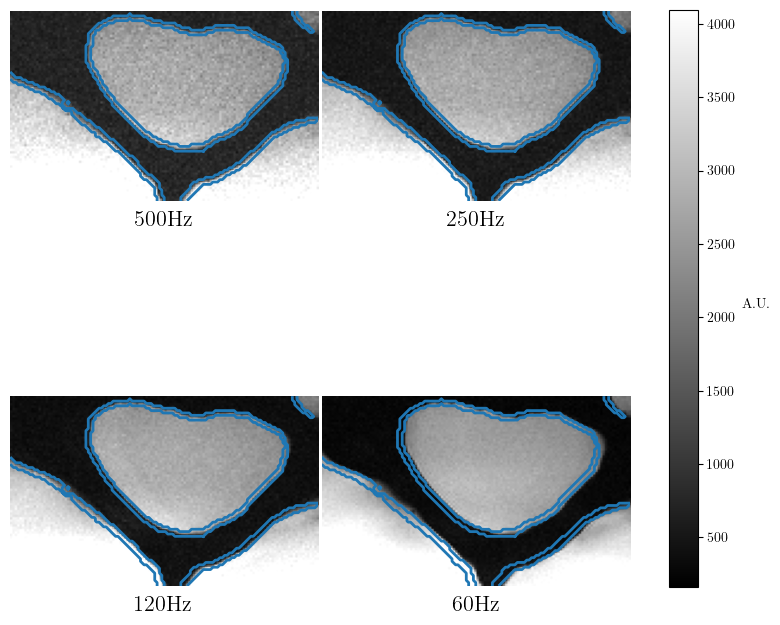

In [124]:
img_idx = 13
plot_ref_contour_on_img(img_idx)

## Changes in 4 ROIs intensities due to shifting of pixels

In [125]:
# Calcualte the mean and median values for the difference maps of 120Hz and 60Hz to the reference of 250Hz
def calc_mean_median_diff():
    '''
    Function for calculating the mean and median difference between the reference image of 250Hz and the other images
    
    Output:
    mean_values (np.ndarray): Array with mean difference values
    median_values (np.ndarray): Array with median difference values'''
    

    mean_values = np.zeros((img_cropped_boundary[0].shape[2], 4, 2))
    median_values = np.zeros((img_cropped_boundary[0].shape[2], 4, 2))
    
    for i in range(img_cropped_boundary[0].shape[2]):
        masks = np.load(f'../ROI/BW_2/slice_{i}.npy')
        
        for l in range(1, 5):
            
            roi = masks == l

            ref = ref_img_boundary[:, :, i].copy()

            ref[~roi] = np.nan

            for k in range(2, len(bw)):
                img = img_cropped_boundary[k][:, :, i].copy()
                img[~roi] = np.nan
                
                mean_diff = np.nanmean(img - ref)
                median_diff = np.nanmedian(img - ref)
                
                mean_values[i, l - 1, k - 2] = mean_diff
                median_values[i, l - 1, k - 2] = median_diff

    return mean_values, median_values

In [126]:
mean_values, median_values = calc_mean_median_diff()

In [127]:
def stack_metrics():
    '''
    Stack mean and median values for both BWs to make it easy to plot in heatmap.

    Input:
    idx (int): Wat BW to stack. 0 = 120Hz, 1 = 60Hz

    Output:
    stacked (np.array): Stacked mean and median values for the BW
    '''
    all_stacked_120 = 0
    all_stacked_60 = 0

    for i in range(2):
        # Extract the two metrics for each mask individually
        mask_1_mean = mean_values[:, 0, i]
        mask_1_median = median_values[:, 0, i]
        mask_2_mean = mean_values[:, 1, i]
        mask_2_median = median_values[:, 1, i]
        mask_3_mean = mean_values[:, 2, i]
        mask_3_median = median_values[:, 2, i]
        mask_4_mean = mean_values[:, 3, i]
        mask_4_median = median_values[:, 3, i]

        # Stack the metrics
        stacked_1 = np.rot90(np.hstack((mask_1_median[:].reshape(-1, 1), mask_1_mean[:].reshape(-1, 1))))
        stacked_2 = np.rot90(np.hstack((mask_2_median[:].reshape(-1, 1), mask_2_mean[:].reshape(-1, 1))))
        stacked_3 = np.rot90(np.hstack((mask_3_median[:].reshape(-1, 1), mask_3_mean[:].reshape(-1, 1))))
        stacked_4 = np.rot90(np.hstack((mask_4_median[:].reshape(-1, 1), mask_4_mean[:].reshape(-1, 1))))

        stacked_12 = np.hstack((stacked_1, stacked_2))
        stacked_34 = np.hstack((stacked_3, stacked_4))

        double_stacked = np.vstack((stacked_12, stacked_34))

        if i == 0:
            all_stacked_120 = double_stacked
        elif i == 1:
            all_stacked_60 = double_stacked

    # Update max absolute value to get correct scaling
    max_abs_val_120 = np.max(np.abs(all_stacked_120))
    max_abs_val_60 = np.max(np.abs(all_stacked_60))
    max_abs_val = max(max_abs_val_120, max_abs_val_60)
        
    return all_stacked_120, all_stacked_60, max_abs_val


In [128]:
def plot_heatmap(all_stacked, max_abs_val, idx):
    '''
    Plot heatmap of the mean and median values for the BWs.
    
    Input:
    all_stacked (np.array): Stacked mean and median values for the specific BW
    max_abs_val (float): Maximum absolute value overall for all BWs for scaling the colorbar
    idx (int): Index of the BW to plot for title
    '''

    plt.figure(figsize=(15, 15))
    plt.imshow(all_stacked, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    plt.title(f'{bw[idx]} Hz Bandwidth', fontsize=20)
    plt.xlabel('Image Slice', fontsize=16)

    # Add arrows pointing left for negative values and right for positive values
    for (i, j), val in np.ndenumerate(all_stacked):
        # i is row, j is column
        if val < -0.01: # Threshold to avoid cluttering with too many arrows
            fc = 'blue'
            if i < 2:
                if j >= 15: # These should not be blue (indicates left-shift)
                    plt.arrow(j + 0.5, i, -0.5, 0, head_width=0.3, head_length=0.3, fc=fc, ec='black')
                else:
                    plt.arrow(j - 0.5, i, 0.5, 0, head_width=0.3, head_length=0.3, fc=fc, ec='black')
            elif i >= 2:
                if j < 15: # These should not be blue (indicates left-shift)
                    plt.arrow(j + 0.5, i, -0.5, 0, head_width=0.3, head_length=0.3, fc=fc, ec='black')
                else:
                    plt.arrow(j - 0.5, i, 0.5, 0, head_width=0.3, head_length=0.3, fc=fc, ec='black')
        
        elif val > 0.01:
            fc = 'red'
            if i < 2:
                if j < 15:
                        plt.arrow(j + 0.5, i, -0.5, 0, head_width=0.3, head_length=0.3, fc=fc, ec='black')
                else:
                    plt.arrow(j - 0.5, i, 0.5, 0, head_width=0.3, head_length=0.3, fc=fc, ec='black')
            if i >= 2:
                if j >= 15:
                    plt.arrow(j + 0.5, i, -0.5, 0, head_width=0.3, head_length=0.3, fc=fc, ec='black')
                else:
                    plt.arrow(j - 0.5, i, 0.5, 0, head_width=0.3, head_length=0.3, fc=fc, ec='black')

    # Create custom y-axis labels
    y_labels = ['Mean', 'Median', 'Mean', 'Median']


    plt.axhline(y=1.5, color='black', linewidth=2)
    plt.axvline(x = 14.5, color = 'black', linewidth = 2)
        
    # Set custom y-axis labels
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

    # Create custom x-axis labels
    x_labels = list(range(15)) + list(range(15))
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)

    # Add text indicating wher each mask is
    plt.text(7, -1.1, r'$\textbf{ROI 1}$', ha='center', va='center', color='black', fontsize=12)
    plt.text(22, -1.1, r'$\textbf{ROI 2}$', ha='center', va='center', color='black', fontsize=12)
    plt.text(7, 4.5, r'$\textbf{ROI 3}$', ha='center', va='center', color='black', fontsize=12)
    plt.text(22, 4.5, r'$\textbf{ROI 4}$', ha='center', va='center', color='black', fontsize=12)
    cbar = plt.colorbar(shrink = 0.3, pad = 0.01)

    cbar.set_label('A.U.', rotation=0, labelpad = 5)

    plt.show()

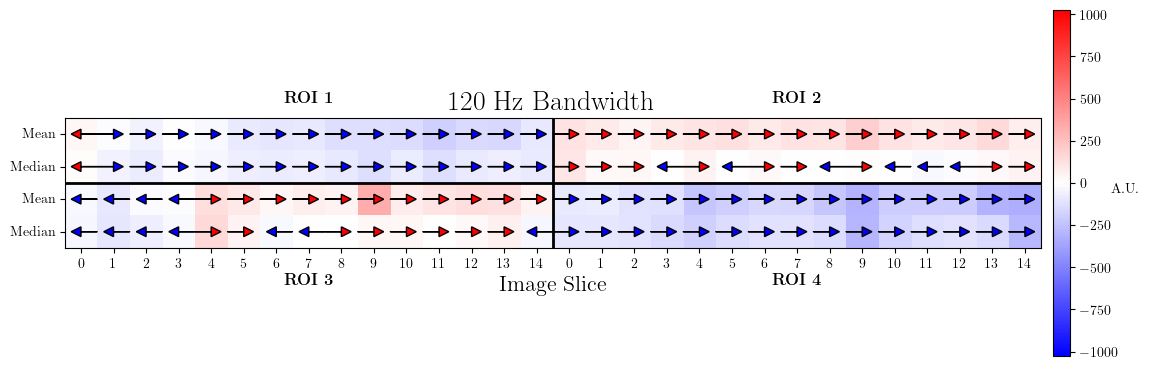

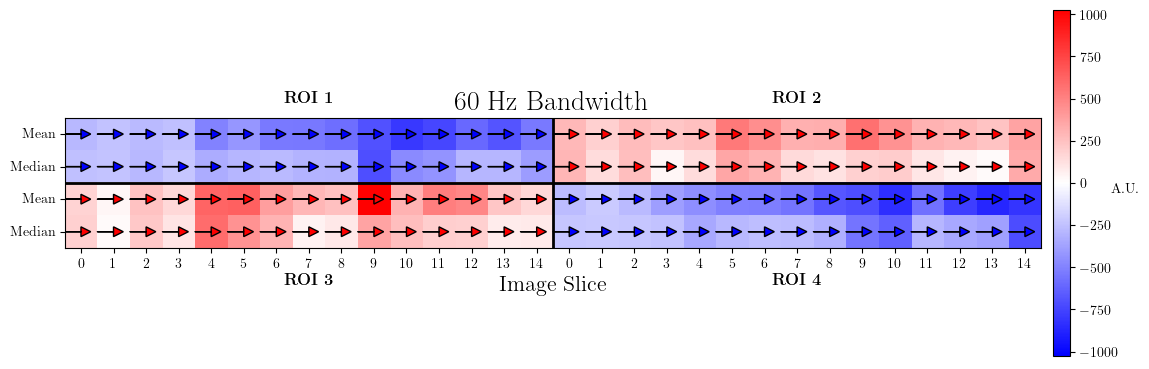

In [129]:
all_stacked_120, all_stacked_60, max_abs_val = stack_metrics()

plot_heatmap(all_stacked_120, max_abs_val, 2)
plot_heatmap(all_stacked_60, max_abs_val, 3)

# Bipolarity of Readout-gradient (part of signal loss in report)

In [133]:
def plot_bipolarity(img_idx):
    '''
    Function for visualizing the effect of readout-gradient on the direction of shift for a low BW image with a reference image in the background with minimal shift.
    
    Input: 
    img_idx (int): Index of the slice to plot'''

    # Use sobel() to get edge detection of the two echos from the 60Hz BW image
    ref_edges = sobel(img_cropped_boundary[3][:, :, img_idx])
    ref_edges_bin = ref_edges > 650 # value from testing on image to get entire boundary in the image
    ref_contours = find_contours(ref_edges_bin)

    img_edges = sobel(img_cropped_boundary_e2[3][:, :, img_idx])
    img_edges_bin = img_edges > 650 # value from testing on image to get entire boundary in the image
    img_contours = find_contours(img_edges_bin)

    plt.figure()

    # Plot the reference image in the background
    img = plt.imshow(ref_img_boundary[:, :, img_idx], cmap='gray')

    # Plot the contours on top
    for n, contour in enumerate(ref_contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color = '#e377c2', label = 'Echo 1' if n == 0 else None)
    for n, contour in enumerate(img_contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color = '#17becf', label = 'Echo 2' if n == 0 else None)
    plt.legend(loc = 'lower left', fontsize = 16)

    cbar = plt.colorbar(img, orientation='vertical', shrink = 0.7)
    cbar.set_label('A.U.', rotation=0, labelpad=15)
    plt.axis('off')
    plt.show()

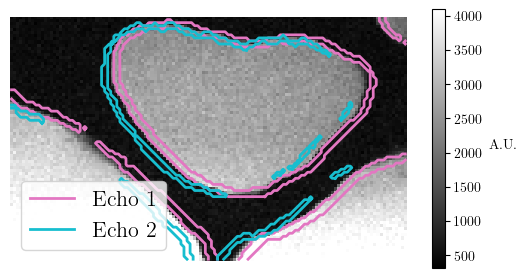

In [134]:
img_idx = 13
plot_bipolarity(img_idx)

# Appendix

In [140]:
def modified_rois(indicies):
    '''
    Function for plotting the slices with modified ROIs
    
    Input:
    indicies (list, int): List of slice indicies to plot
    '''

    fig = plt.figure(figsize = (20, 5))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1.0, 1.0, 1.0, 0.05] ) 

    axs = [fig.add_subplot(gs[i, j]) for i in range(1) for j in range(3)]

    min_val = np.min(img_cropped_boundary[0][:, :, indicies])
    max_val = np.max(img_cropped_boundary[0][:, :, indicies])

    for i in range(len(indicies)):
        # Load the mask for the ROIs
        mask = np.load(f'../ROI/BW_2/slice_{indicies[i]}.npy')
        axs[i].set_title(f'Slice {indicies[i]}', fontsize = 16)
        # Plot the image
        img = axs[i].imshow(img_cropped_boundary[0][:, :, indicies[i]], cmap = 'gray', vmin = min_val, vmax = max_val)

        # Find and plot contours for each ROI
        for k in range(1, 5):
            roi = mask == k
            contours = find_contours(roi, 0.5)
            for contour in contours:
                axs[i].plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)

        axs[i].axis('off')


    cax = fig.add_subplot(gs[0, 3])
    cbar = fig.colorbar(img, cax = cax, orientation='vertical', fraction=0.021, pad=0.04)
    cbar.set_label('A.U.', rotation=0, labelpad=15)

    plt.subplots_adjust(wspace = 0.05, hspace = 0.05)


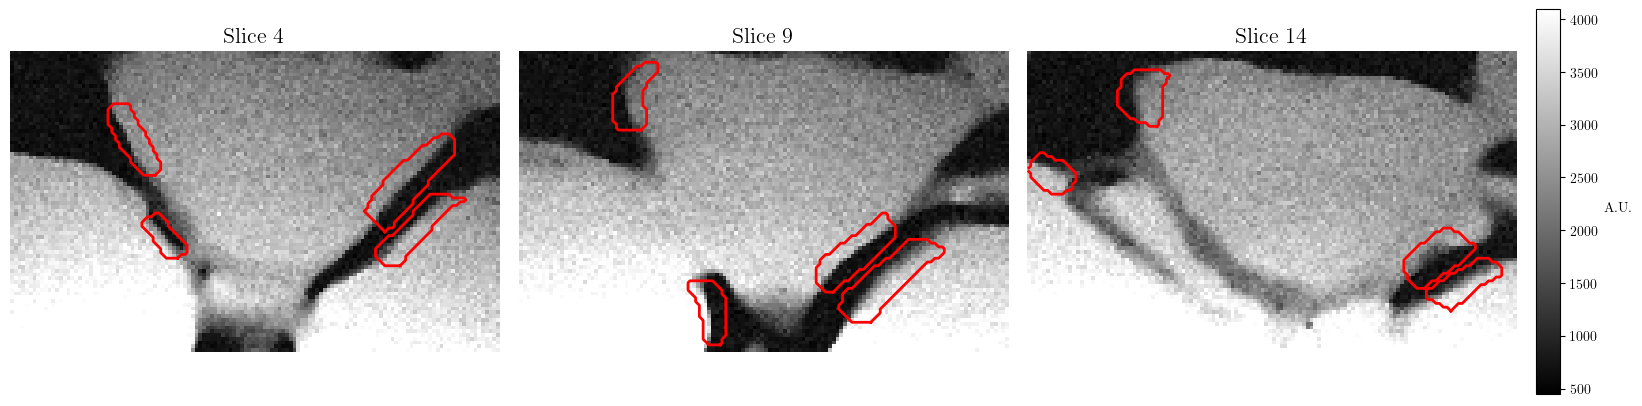

In [141]:
indicies = [4, 9, 14]
modified_rois(indicies)